In [1]:
import json
import sys
from collections import defaultdict, Counter
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

from utils.fix_label import fix_general_label_error

EXPERIMENT_DOMAINS = ["none", "hotel", "train", "restaurant", "attraction", "taxi"]
DOMAIN_INDICES = dict()
for domain in EXPERIMENT_DOMAINS:
    DOMAIN_INDICES[domain] = len(DOMAIN_INDICES)
def get_slot_information():
    ontology = json.load(open("data/multi-woz/MULTIWOZ2.1/ontology.json", 'r'))
    ontology_domains = dict([(k, v) for k, v in ontology.items() if k.split("-")[0] in EXPERIMENT_DOMAINS])
    SLOTS = [k.replace(" ","").lower() if ("book" not in k) else k.lower() for k in ontology_domains.keys()]
    return SLOTS
ALL_SLOTS = get_slot_information()

def fix_none_typo(value):
    if value in ("not men", "not", "not mentioned", "", "not mendtioned", "fun", "art"):
        return 'none'
    else:
        return value

In [2]:
# loading data

filename = 'data/train_dials.json'
with open(filename) as fp:
    dialogue_data = json.load(fp)
    
filename = 'data/dev_dials.json'

dialogue_dev_data = dict()
with open(filename) as fp:
    for dialogue in json.load(fp):
        dialogue['dialogue'].sort(key=lambda x: int(x['turn_idx']))
        dialogue_dev_data[dialogue['dialogue_idx']] = dialogue

max_num_turn = max(max(turn['turn_idx'] for turn in dialogue['dialogue']) for dialogue in dialogue_data)
max_num_turn

21

In [3]:
# calculate distribution of slots at turns

slot_names = set()
slot_turn_pairs = Counter()
for dialogue in dialogue_data:
    for turn in dialogue['dialogue']:
        turn_idx = turn['turn_idx']
        for node_key, node_value in turn['turn_label']:
            if fix_none_typo(node_value) == 'none':
                continue
            node_key = node_key.replace(' ', '-')
            slot_names.add(node_key)
            slot_turn_pairs[(node_key, turn_idx)] += 1
            
slot_names = list(slot_names)
slot_names.sort()
slot_turn_pairs

Counter({('hotel-pricerange', 0): 429,
         ('hotel-type', 0): 623,
         ('hotel-parking', 1): 350,
         ('hotel-book-day', 2): 468,
         ('hotel-book-people', 2): 459,
         ('hotel-book-stay', 2): 486,
         ('hotel-book-stay', 3): 485,
         ('train-destination', 0): 791,
         ('train-arriveby', 0): 263,
         ('train-departure', 1): 745,
         ('train-day', 2): 300,
         ('train-book-people', 3): 299,
         ('hotel-stars', 4): 262,
         ('hotel-internet', 4): 169,
         ('hotel-name', 5): 332,
         ('hotel-book-day', 6): 229,
         ('hotel-book-people', 6): 222,
         ('hotel-book-stay', 6): 253,
         ('hotel-area', 0): 471,
         ('hotel-internet', 0): 392,
         ('hotel-pricerange', 1): 459,
         ('hotel-name', 2): 445,
         ('hotel-type', 2): 259,
         ('train-departure', 5): 245,
         ('train-book-people', 6): 182,
         ('train-leaveat', 6): 81,
         ('train-destination', 6): 85,
      

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f2e04b62150>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f2e0506be50>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f2e056c5190>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f2dfa4b8110>}

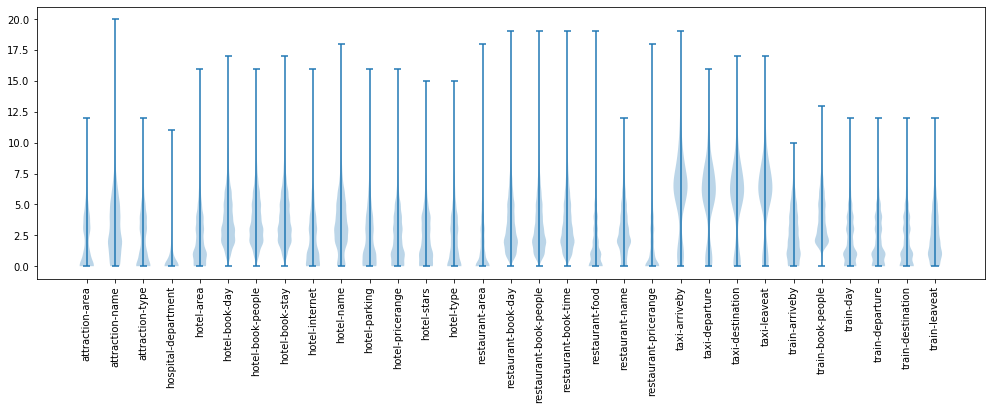

In [4]:
#slot_names_domain = [name for name in slot_names if name.startswith('restaurant-')]
slot_names_domain = slot_names
data = np.array([
    [slot_idx, turn_idx, slot_turn_pairs[(slot_names_domain[slot_idx], turn_idx)]] for slot_idx in range(len(slot_names_domain)) for turn_idx in range(max_num_turn+1)
])
x = data[:, 0]
y = data[:, 1]
s = data[:, 2]
plt.figure(figsize=(17, 5))
#plt.scatter(x, y, s)
plt.xticks(1+np.arange(len(slot_names_domain)), slot_names_domain, rotation='vertical')

violindata = [
    [turn_idx for turn_idx in range(max_num_turn+1) for _ in range(slot_turn_pairs[(slot_names_domain[slot_idx], turn_idx)])]
    for slot_idx in range(len(slot_names_domain))
]
#violindata
plt.gca().violinplot(violindata)

In [5]:
slot_indices = dict((name, idx) for idx, name in enumerate(slot_names))
slot_distribution = [[] for _ in range(len(slot_names))]
for dialogue in dialogue_data:
    for turn in dialogue['dialogue']:
        turn_idx = turn['turn_idx']
        for node_key, node_value in turn['turn_label']:
            if fix_none_typo(node_value) == 'none':
                continue
            node_key = node_key.replace(' ', '-')
            slot_distribution[slot_indices[node_key]].append(turn_idx / len(dialogue['dialogue']))

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f2dfa27b410>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f2e34329450>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f2df995e8d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f2df995e350>}

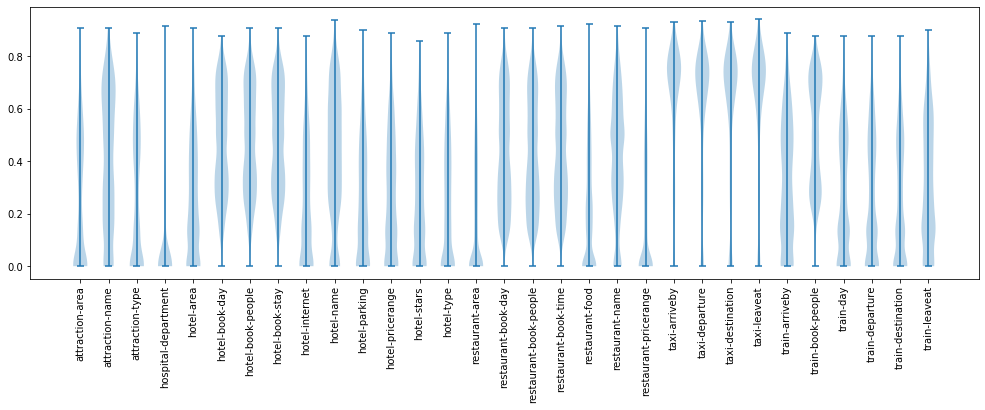

In [6]:

plt.figure(figsize=(17, 5))
#plt.scatter(x, y, s)
plt.xticks(1+np.arange(len(slot_names_domain)), slot_names_domain, rotation='vertical')
plt.gca().violinplot(slot_distribution)

In [10]:
test_domain = 'train'
#test_domain = None

def remove_none_slots(belief):
    for slot_tuple in belief:
        domain, slot_name, slot_value = slot_tuple.split('-', maxsplit=2)
        if slot_value == 'none':
            continue
            
        if test_domain is not None and domain != test_domain:
            continue
            
        yield slot_tuple

def get_joint_accuracy(turn):
    return float(set(remove_none_slots(turn['turn_belief'])) == set(remove_none_slots(turn['pred_bs_ptr'])))

def print_turn(dialogue_id, model_name, up_to=-1):
    dialogue = dialogue_dev_data[dialogue_id]
    if up_to < 0:
        up_to = len(dialogue['dialogue'])
    
    print()
    print(dialogue_id + '/' + str(up_to))
    for turn_idx in range(up_to + 1):
        if turn_idx > 0:
            print('S: ' + dialogue['dialogue'][turn_idx]['system_transcript'])
        print('U: ' + dialogue['dialogue'][turn_idx]['transcript'])
    pred_data_all[model_name][dialogue_id][str(turn_idx)]['turn_belief'].sort()
    pred_data_all[model_name][dialogue_id][str(turn_idx)]['pred_bs_ptr'].sort()
    print('Ann:', pred_data_all[model_name][dialogue_id][str(turn_idx)]['turn_belief'])
    print('Pred:', pred_data_all[model_name][dialogue_id][str(turn_idx)]['pred_bs_ptr'])
    

In [4]:
ALL_MODELS = ['taxi2train-pct0', 'taxi2train-pct0-tr5', 'taxi2train-pct0-tr6', 'taxi2train-pct5', 'baseline21']

pred_data_all = dict()
for modelname in ALL_MODELS:
    with open('./model-' + modelname + '/predictions/' + (test_domain if test_domain else 'full') + '/prediction_TRADE_dev.json') as fp:
        pred_data = json.load(fp)
        pred_data_all[modelname] = pred_data


In [11]:
#test_domain = 'train'
for modelname in ALL_MODELS:
    count = 0
    accuracy = 0
    
    for dialogue_id, dialogue in dialogue_dev_data.items():
        if test_domain is not None and test_domain not in dialogue['domains']:
            continue
        
        pred = pred_data_all[modelname][dialogue_id]
        
        for turn in dialogue['dialogue']:
            turn_pred = pred[str(turn['turn_idx'])]
            count += 1
            accuracy += get_joint_accuracy(turn_pred)

    print(modelname, count, accuracy, accuracy/count, sep='\t')

taxi2train-pct0	3709	859.0	0.23159881369641414
taxi2train-pct0-tr5	3709	1320.0	0.35589107576166085
taxi2train-pct0-tr6	3709	1055.0	0.28444324615799405
taxi2train-pct5	3709	2628.0	0.7085467781073066
baseline21	3709	3074.0	0.8287948234025344


In [9]:
modelname = 'baseline21'

max_num_turn = max(len(dlg) for dlg in pred_data_all[modelname].values())
per_turn_count = np.zeros((max_num_turn+1,), dtype=np.int32)
per_turn_accuracy = np.zeros((max_num_turn+1,), dtype=np.int32)
per_turn_recovery = np.zeros((max_num_turn+1,), dtype=np.int32)

for dialogue_id, dialogue in dialogue_dev_data.items():
    #if test_domain not in dialogue['domains']:
    #    continue

    pred = pred_data_all[modelname][dialogue_id]

    prev_turn_ok = 0
    for turn in dialogue['dialogue']:
        turn_idx = turn['turn_idx']
        turn_pred = pred[str(turn_idx)]
        per_turn_count[turn_idx] += 1
        turn_ok = get_joint_accuracy(turn_pred)
        per_turn_accuracy[turn_idx] += turn_ok
        
        if turn_ok and not prev_turn_ok:
            per_turn_recovery[turn_idx] += 1
        prev_turn_ok = turn_ok
            
data = [
    [turn_idx, per_turn_count[turn_idx], per_turn_accuracy[turn_idx],
     per_turn_accuracy[turn_idx] / per_turn_count[turn_idx],
     per_turn_recovery[turn_idx],
     per_turn_recovery[turn_idx] / per_turn_count[turn_idx],
     pow(0.96, turn_idx+1)]
    for turn_idx in range(max_num_turn)
]
pd.DataFrame(data, columns=['turn_idx', 'count', 'accurate count', 'accuracy', 'recovered count', 'recovered accuracy', 'ceiling'])

,turn_idx,count,accurate count,accuracy,recovered count,recovered accuracy,ceiling
0,0,1000,899,0.899000,899,0.899000,0.960000
1,1,1000,735,0.735000,36,0.036000,0.921600
2,2,997,580,0.581745,54,0.054162,0.884736
3,3,959,475,0.495308,65,0.067779,0.849347
4,4,892,375,0.420404,58,0.065022,0.815373
5,5,811,274,0.337855,38,0.046856,0.782758
6,6,656,177,0.269817,31,0.047256,0.751447
7,7,475,108,0.227368,19,0.040000,0.721390
8,8,280,48,0.171429,7,0.025000,0.692534
9,9,153,25,0.163399,5,0.032680,0.664833


In [12]:
per_turn_accuracy_all = dict()
for modelname in ALL_MODELS:
    pred_data = pred_data_all[modelname]
    max_num_turn = max(len(dlg) for dlg in pred_data.values())
    per_turn_count = np.zeros((max_num_turn+1,), dtype=np.int32)
    per_turn_accuracy = np.zeros((max_num_turn+1,), dtype=np.int32)
    per_turn_accuracy_all[modelname] = per_turn_accuracy

    for dialogue_id, dialogue in pred_data.items():
        for turn_idx, turn in dialogue.items():
            turn_idx = int(turn_idx)
            per_turn_count[turn_idx] += 1
            per_turn_accuracy[turn_idx] += get_joint_accuracy(turn)


data = [
    ([turn_idx, per_turn_count[turn_idx]] + [
            #100 * ((per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]) - (per_turn_accuracy[turn_idx-1] / per_turn_count[turn_idx-1])
            #       if turn_idx > 0 else
            #       (per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]))
            100 * ((per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]))
            for per_turn_accuracy in per_turn_accuracy_all.values()])
    for turn_idx in range(max_num_turn)
]
pd.DataFrame(data, columns=['turn_idx', 'count']+ list(per_turn_accuracy_all.keys()))

,turn_idx,count,taxi2train-pct0,taxi2train-pct0-tr5,taxi2train-pct0-tr6,taxi2train-pct5,baseline21
0,0,484,58.057851,90.702479,81.198347,93.801653,96.487603
1,1,484,52.892562,73.553719,57.851240,89.669421,96.074380
2,2,484,35.537190,52.272727,40.909091,78.305785,85.950413
3,3,482,18.257261,30.082988,21.369295,69.502075,80.497925
4,4,469,7.462687,15.778252,10.234542,62.260128,77.398721
5,5,447,3.803132,7.606264,4.474273,57.718121,75.167785
6,6,355,1.408451,2.253521,1.690141,54.647887,74.084507
7,7,247,1.214575,2.429150,1.619433,55.060729,73.279352
8,8,135,1.481481,2.962963,2.222222,55.555556,73.333333
9,9,69,1.449275,1.449275,1.449275,59.420290,79.710145


In [13]:
per_num_slot_accuracy_all = dict()
max_num_slots = 0
for dialogue in pred_data_all['baseline21'].values():
    for turn in dialogue.values():
        max_num_slots = max(max_num_slots, len(set(remove_none_slots(turn['turn_belief']))))
max_num_slots += 1
for modelname in ALL_MODELS:
    pred_data = pred_data_all[modelname]
    per_num_slot_count = np.zeros((max_num_turn+1,), dtype=np.int32)
    per_num_slot_accuracy = np.zeros((max_num_turn+1,), dtype=np.int32)
    per_num_slot_accuracy_all[modelname] = per_num_slot_accuracy

    for dialogue_id, dialogue in pred_data.items():
        for turn_idx, turn in dialogue.items():
            num_slot = len(set(remove_none_slots(turn['turn_belief'])))
            per_num_slot_count[num_slot] += 1
            per_num_slot_accuracy[num_slot] += get_joint_accuracy(turn)

data = [
    ([num_slot, per_num_slot_count[num_slot]] + [
            #100 * ((per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]) - (per_turn_accuracy[turn_idx-1] / per_turn_count[turn_idx-1])
            #       if turn_idx > 0 else
            #       (per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]))
            100 * ((per_num_slot_accuracy[num_slot] / per_num_slot_count[num_slot]))
            for per_num_slot_accuracy in per_num_slot_accuracy_all.values()])
    for num_slot in range(max_num_slots)
]
pd.DataFrame(data, columns=['# slots', 'count']+ list(per_num_slot_accuracy_all.keys()))

,# slots,count,taxi2train-pct0,taxi2train-pct0-tr5,taxi2train-pct0-tr6,taxi2train-pct5,baseline21
0,0,859,100.349243,99.883586,99.883586,99.883586,99.534342
1,1,88,0.000000,82.954545,54.545455,89.772727,92.045455
2,2,344,0.000000,63.081395,38.662791,79.069767,87.500000
3,3,206,0.000000,33.980583,9.223301,48.058252,64.563107
4,4,1146,0.000000,8.987784,0.000000,64.659686,81.500873
5,5,1028,0.000000,0.194553,0.000000,56.420233,74.416342
6,6,38,0.000000,0.000000,0.000000,5.263158,13.157895


In [15]:
count = 0
accuracy_both = 0
accuracy_neither = 0
accuracy_only_baseline = 0
accuracy_only_improved = 0
max_num_slots = 0
for dialogue in pred_data_all['baseline21'].values():
    for turn in dialogue.values():
        max_num_slots = max(max_num_slots, len(set(remove_none_slots(turn['turn_belief']))))
max_num_slots += 1
max_num_turn = max(len(dlg) for dlg in pred_data_all['baseline21'].values())

per_num_slot_stats = dict()
for num_slot in range(max_num_slots):
    for turn_idx in range(max_num_turn):
        per_num_slot_stats[(num_slot, turn_idx)] = {
            'count': 0,
            'accuracy_both': 0,
            'accuracy_neither': 0,
            'accuracy_only_baseline': 0,
            'accuracy_only_improved': 0,
        }

baseline_model = 'taxi2train-pct0-tr5'
improved_model = 'taxi2train-pct0-tr6'

for dialogue_id, dialogue in dialogue_dev_data.items():
    if test_domain is not None and test_domain not in dialogue['domains']:
        continue
    
    for turn in dialogue['dialogue']:
        turn_idx = str(turn['turn_idx'])
        baseline_ok = get_joint_accuracy(pred_data_all[baseline_model][dialogue_id][turn_idx])
        improved_ok = get_joint_accuracy(pred_data_all[improved_model][dialogue_id][turn_idx])
        num_slot = len(set(remove_none_slots(pred_data_all[baseline_model][dialogue_id][turn_idx]['turn_belief'])))
        count += 1
        
        stat_key = (num_slot, turn['turn_idx'])
        per_num_slot_stats[stat_key]['count'] += 1
        
        if baseline_ok and improved_ok:
            accuracy_both += 1
            per_num_slot_stats[stat_key]['accuracy_both'] += 1
        elif baseline_ok:
            accuracy_only_baseline += 1
            per_num_slot_stats[stat_key]['accuracy_only_baseline'] += 1
        elif improved_ok:
            accuracy_only_improved += 1
            per_num_slot_stats[stat_key]['accuracy_only_improved'] += 1
        else:
            accuracy_neither += 1
            per_num_slot_stats[stat_key]['accuracy_neither'] += 1
        
print('# overall')
print('total =', count)
print('both =', accuracy_both, '(%.1f%%)' % (100* accuracy_both/count,))
print('lost =', accuracy_only_baseline, '(%.1f%%)' % (100* accuracy_only_baseline/count,))
print('gained =', accuracy_only_improved, '(%.1f%%)' % (100* accuracy_only_improved/count,))
print('neither =', accuracy_neither, '(%.1f%%)' % (100* accuracy_neither/count,))

for num_slot in range(max_num_slots):
    for turn_idx in range(max_num_turn):
        stat_key = (num_slot, turn_idx)
        count = per_num_slot_stats[stat_key]['count']
        if count == 0:
            continue
        print()
        print('# %d slots, turn %d' % (num_slot, turn_idx))
        print('total =', count)
        print('both =', per_num_slot_stats[stat_key]['accuracy_both'],
              '(%.1f%%)' % (100* per_num_slot_stats[stat_key]['accuracy_both']/count,))
        print('lost =', per_num_slot_stats[stat_key]['accuracy_only_baseline'],
              '(%.1f%%)' % (100* per_num_slot_stats[stat_key]['accuracy_only_baseline']/count,))
        print('gained =', per_num_slot_stats[stat_key]['accuracy_only_improved'],
              '(%.1f%%)' % (100* per_num_slot_stats[stat_key]['accuracy_only_improved']/count,))
        print('neither =', per_num_slot_stats[stat_key]['accuracy_neither'],
              '(%.1f%%)' % (100* per_num_slot_stats[stat_key]['accuracy_neither']/count,))

# overall
total = 3709
both = 1030 (27.8%)
lost = 290 (7.8%)
gained = 25 (0.7%)
neither = 2364 (63.7%)

# 0 slots, turn 0
total = 279
both = 278 (99.6%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 1 (0.4%)

# 0 slots, turn 1
total = 255
both = 255 (100.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 0 slots, turn 2
total = 172
both = 170 (98.8%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 2 (1.2%)

# 0 slots, turn 3
total = 88
both = 88 (100.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 0 slots, turn 4
total = 35
both = 35 (100.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 0 slots, turn 5
total = 17
both = 17 (100.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 0 slots, turn 6
total = 5
both = 5 (100.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 0 slots, turn 7
total = 3
both = 2 (66.7%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 1 (33.3%)

# 0 slots, turn 8
total = 2
both = 2 (100.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)


In [17]:
baseline_model = 'taxi2train-pct0-tr5'
improved_model = 'taxi2train-pct0-tr6'

count = 0
for dialogue_id, dialogue in dialogue_dev_data.items():
    if test_domain is not None and test_domain not in dialogue['domains']:
        continue
    
    for turn in dialogue['dialogue']:
        turn_idx = str(turn['turn_idx'])
        num_slot = len(set(remove_none_slots(pred_data_all[baseline_model][dialogue_id][turn_idx]['turn_belief'])))
        if num_slot > 2:
            continue
        
        baseline_ok = get_joint_accuracy(pred_data_all[baseline_model][dialogue_id][turn_idx])
        improved_ok = get_joint_accuracy(pred_data_all[improved_model][dialogue_id][turn_idx])
        
        if baseline_ok and not improved_ok:
            count += 1
            print_turn(dialogue_id, improved_model, int(turn_idx))
            
print(count)


PMUL3470.json/4
U: i am looking for a specific hotel , its name is express by holiday inn cambridge
S: i have the express by holiday inn cambridge located on 1517 norman way , coldhams business park . their phone number is 01223866800 . would you like to know anything else ?
U: yes , could you book the hotel room for me for 7 people ?
S: yes , of course . what day would you like to stay ?
U: monday , please . there will be 7 of us and we'd like to stay for 4 days .
S: here is the booking information:booking was successful . reference number is : 5f8g6j1g
U: thank you . i would also like to book a train , please .
S: sure , which stations will you be traveling between ?
U: i will be going from cambridge to birmingham new street .
Ann: ['train-day-none', 'train-departure-cambridge', 'train-destination-birmingham new street']
Pred: ['train-departure-cambridge new street', 'train-destination-birmingham new street']

PMUL1557.json/0
U: i need a train on thursday .
Ann: ['train-day-thursday

In [25]:
baseline_model = '21notrainfix'
improved_model = 'tr1-taxi2trainfix'
test_domain = 'train'

def has_domain(belief, domain):
    return any(slot.split('-', maxsplit=1)[0] == domain for slot in belief)

count = 0
for dialogue_id, dialogue in dialogue_dev_data.items():
    if test_domain not in dialogue['domains']:
        continue
    
    for turn in dialogue['dialogue']:
        turn_idx = turn['turn_idx']
        improved_pred = pred_data_all[improved_model][dialogue_id][str(turn_idx)]
        
        if has_domain(improved_pred['pred_bs_ptr'], 'train') and has_domain(improved_pred['pred_bs_ptr'], 'taxi'):
            print_turn(dialogue_id, improved_model, turn_idx)
            count += 1
            if count >= 100:
                break


PMUL0716.json/0
U: i need a taxi to pick us up in centre at 11:45
Ann: ['taxi-leaveat-11:45']
Pred: ['train-leaveat-11:45', 'taxi-leaveat-11:45']

PMUL4431.json/5
U: i am traveling to cambridge and looking forward to try local restaurant -s .
S: we have lots to explore ! i can help you find 1 , if you would like .
U: great ! the restaurant should serve scandinavian food and should be in the east .
S: i am sorry there are no restaurant -s serving scandinavian food . is there another type of food you might like to try ?
U: how about indian food ?
S: i have 4 different indian place -s to eat . 2 are moderate -ly priced and 2 are expensive . do you have a preference ?
U: i perfer a moderate price range . whatever you suggest . i need to book a table for 1 at 13:15 on tuesday .
S: okay , i have booked a table at the curry prince for you . the reference number is nz5wkz9v . the table will be reserved for 15 minutes .
U: thank you . could i also have information on trains that depart from ca

In [11]:
pred_data = pred_data_all['baseline21']

with open('turn1-errors.txt', 'w') as fp:
    count = 0
    for dialogue_id, dialogue in pred_data.items():
        turn = dialogue['1']
        num_considered_turns = 2

        if not get_joint_accuracy(turn):
            turn_objs = dialogue_dev_data[dialogue_id]['dialogue'][ : num_considered_turns]
            print(dialogue_id, file=fp)
            for turn_obj in turn_objs:
                if turn_obj['system_transcript']:
                    print('S:', turn_obj['system_transcript'], file=fp)
                print('U:', turn_obj['transcript'], file=fp)
            print('Ann:', json.dumps(list(sorted(turn['turn_belief']))), file=fp)
            print('Pred:', json.dumps(list(sorted(turn['pred_bs_ptr']))), file=fp)
            print(file=fp)
            count += 1
    #if count >= :
    #    break

In [9]:
def get_turn_domains(turn):
    for slot_tuple in turn['turn_belief']:
        domain, slot_name, slot_value = slot_tuple.split('-')
        yield domain


normal_count = 0
normal_accuracy = 0
trans_count = 0
trans_accuracy = 0
delayed_trans_count = 0
delayed_trans_accuracy = 0
end_normal_count = 0
end_normal_accuracy = 0
end_trans_count = 0
end_trans_accuracy = 0
transition_count = 0

for dialogue_id, dialogue in pred_data.items():
    prev_turn_domains = set()
    delayed_trans_distance = 0
    had_transition = False
    for turn_idx, turn in dialogue.items():
        turn_idx = int(turn_idx)
        #turn_id = dialogue_id + '/' + str(turn_idx)
        
        our_turn_domains = set(get_turn_domains(turn))
        our_turn_accuracy = get_joint_accuracy(turn)
        normal_count += 1
        normal_accuracy += our_turn_accuracy
        if len(prev_turn_domains) > 0:
            is_transition = False
            for dom in our_turn_domains:
                if dom not in prev_turn_domains:
                    is_transition = True
                    break
            if is_transition:
                trans_count += 1
                trans_accuracy += our_turn_accuracy
                delayed_trans_distance = 100
                had_transition = True
        if delayed_trans_distance > 0:
            delayed_trans_count += 1
            delayed_trans_accuracy += our_turn_accuracy
            delayed_trans_distance -= 1
        if had_transition:
            transition_count += 1
        prev_turn_domains = our_turn_domains
        if turn_idx == len(dialogue)-1:
            end_normal_count += 1
            end_normal_accuracy += our_turn_accuracy
            if had_transition:
                end_trans_count += 1
                end_trans_accuracy += our_turn_accuracy

assert trans_count > 0
(normal_accuracy / normal_count, trans_accuracy / trans_count, delayed_trans_accuracy / delayed_trans_count,
 end_normal_accuracy / end_normal_count, end_trans_accuracy / end_trans_count, transition_count / normal_count)

(0.38988337401681583,
 0.13725490196078433,
 0.23787878787878788,
 0.216,
 0.1390728476821192,
 0.08950366151342555)

In [10]:
def get_slot_names(belief):
    for slot_tuple in belief:
        domain, slot_name, slot_value = slot_tuple.split('-')
        if slot_value == 'none':
            continue
        yield domain + '-' + slot_name
        
def get_name_accuracy(turn):
    return float(set(get_slot_names(turn['turn_belief'])) == set(get_slot_names(turn['pred_bs_ptr'])))

count = 0
joint_accuracy = 0
name_accuracy = 0

for dialogue_id, dialogue in pred_data.items():
    for turn_idx, turn in dialogue.items():
        #turn_idx = int(turn_idx)
        count += 1
        joint_accuracy += get_joint_accuracy(turn)
        name_accuracy += get_name_accuracy(turn)

(joint_accuracy / count, name_accuracy / count)

(0.38988337401681583, 0.48576078112286414)

In [11]:
count = 0
insertions = 0
name_errors = 0
max_num_turns = max(len(dialogue) for dialogue in pred_data.values())
count_per_turn = np.zeros((max_num_turns+1,), dtype=np.int32)
name_accuracy_per_turn = np.zeros((max_num_turns+1,), dtype=np.int32)
insertions_per_turn = np.zeros((max_num_turns+1,), dtype=np.int32)

for dialogue_id, dialogue in pred_data.items():
    for turn_idx, turn in dialogue.items():
        turn_idx = int(turn_idx)
        count += 1
        count_per_turn[turn_idx] += 1
        turn_belief = set(get_slot_names(turn['turn_belief']))
        pred_bs_ptr = set(get_slot_names(turn['pred_bs_ptr']))
        
        our_name_accuracy = int(turn_belief == pred_bs_ptr)
        name_accuracy_per_turn[turn_idx] += our_name_accuracy
        name_errors += 1 - our_name_accuracy
        
        is_insertion = False
        for slot_name in pred_bs_ptr:
            if slot_name not in turn_belief:
                is_insertion = True
                break
        if is_insertion:
            insertions += 1
            insertions_per_turn[turn_idx] += 1

(insertions, name_errors, insertions/name_errors, count, insertions / count)

(2269, 3792, 0.5983649789029536, 7374, 0.3077027393544887)

0	1000	106	82
1	1000	172	146
2	997	258	174
3	959	270	219
4	892	316	221
5	811	328	207
6	656	293	183
7	475	217	133
8	280	148	65
9	153	81	41
10	85	46	27
11	36	21	11
12	16	9	6
13	8	3	4
14	3	1	1
15	2	0	2
16	1	0	1


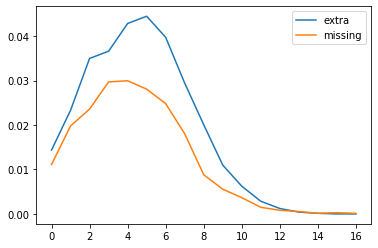

In [12]:
x = np.arange(max_num_turns)
y1 = []
y2 = []

for turn_idx in range(max_num_turns):
    print(turn_idx, count_per_turn[turn_idx], insertions_per_turn[turn_idx],
          count_per_turn[turn_idx] - name_accuracy_per_turn[turn_idx] - insertions_per_turn[turn_idx],
          sep='\t')
    
    insertion_per_turn = insertions_per_turn[turn_idx] / count_per_turn[turn_idx]
    name_error_per_turn = 1 - (name_accuracy_per_turn[turn_idx] / count_per_turn[turn_idx])
    missing_per_turn = name_error_per_turn - insertion_per_turn
    y1.append(insertions_per_turn[turn_idx] / count)
    y2.append(missing_per_turn * count_per_turn[turn_idx] / count)
    
    

plt.plot(x, y1, label='extra')
plt.plot(x, y2, label='missing')
plt.legend()